# Multiple points of view

## Overview

In this tutorial, you will learn how to render a given scene from multiple points of view.  
This can be very practical if you wish to generate a large synthetic dataset, or are doing some multi-view optimization.

<div class="admonition important alert alert-block alert-info">

🚀 **What will you learn?**

<ul>
  <li>Load Mitsuba objects</li>
  <li>Load a sensor</li>
  <li>Render a scene for a specific sensor</li>
</ul>

</div>

## Step 1 - Import Mitsuba

Let us start by importing Mitsuba and setting the variant.

In [1]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")

## Step 2 - Loading a scene


In previous tutorials, we have seen how to load a Mitsuba scene description from an XML file. It is also possbile to load a scene by describing it as a Python dictionnary. 

In fact, the `mi.load_dict` function allows us to load any Mitsuba object by describing it as a `dict`. The exact form of the dictionnary can usually be easily deduced from the equivalent XML representation. The #TODO (link) [plugin documentation]() also gives examples for every plugin in both their XML and `dict` representations. There are no differences between what is achievable with both representations.

In [2]:
scene = mi.load_dict(
    {
        "type": "scene",
        "integrator": {"type": "path"},
        "light": {"type": "constant"},
        "sensor": {"type": "perspective"},
        "teapot": {
            "type": "ply",
            "filename": "../../scenes/meshes/teapot.ply",
            "to_world": mi.ScalarTransform4f.translate([0, 0, -1.5]),
            "bsdf": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.1, 0.2, 0.3]},
            },
        },
    }
)

2022-04-06 16:58:21 INFO main [Scene] Building scene in OptiX ..

2022-04-06 16:58:21 INFO main [Scene] OptiX ready. (took 65ms)

The scene we have just loaded is a simple teapot under constant lightning conditions, we will be rendering it from mulitple points of view by moving  around it in a circular motion.

Note that the scene description specifies a sensor, this is just a placeholder and it could be omitted entirely. Mitsuba would have simply warned you that it added a default sensor to the scene if it were omitted.

## Step 3 - Loading sensors

Mitsuba provides a high level `mi.Sensor` abstraction, along with a `mi.Film` abstraction, which define how radiance should be recorded in our scene. For the purposes of this tutorial, we will focus on the sensor's position and skip over all other parameters. Of course, if you wished to do so, it is entirely possible to define multiple radically different sensors. You can learn more about the different types of sensors and films that are included in Mitsuba in the #TODO (link) [plugin documentation](). 

Let's define a helper function `load_sensor` that loads a sensor with a specific position given as input in spherical coordinates. As previously mentionned, `mi.load_dict` can be used to load a single Mitsuba object too and not just entire scenes, so let's make use of it here.

In [3]:
def load_sensor(r, phi, theta):
    origin = (
        mi.ScalarTransform4f.rotate([0, 0, 1], phi)
        * mi.ScalarTransform4f.rotate([0, 1, 0], theta)
    ) @ mi.ScalarPoint3f([0, 0, r])

    return mi.load_dict(
        {
            "type": "perspective",
            "fov_axis": "smaller",
            "near_clip": 0.001,
            "far_clip": 100.0,
            "focus_distance": 1000,
            "fov": 39.3077,
            "to_world": mi.ScalarTransform4f.look_at(
                origin=origin, target=[0, 0, 0], up=[0, 0, 1]
            ),
            "sampler": {"type": "independent", "sample_count": 256},
            "film": {
                "type": "hdrfilm",
                "width": 256,
                "height": 256,
                "rfilter": {
                    "type": "tent",
                },
                "pixel_format": "rgb",
            },
        }
    )

## Step 4 - Rendering from a specific sensor

The `mi.render` #TODO (link) function can take quite a few aditional arguments. We have already seen that we can specify the number of samples per pixel with the keyword argument `spp`. We can also dynamically specify a sensor with the `sensor` keyword argument that should be used instead of the sensor that is already defined in the scene. 

The previous [tutorial]() #TODO (link) showed how `mi.traverse` can be used to edit scenes. That same mechanism could be used to edit the sensor after each render. However, we would be limited to editing the parameters that are exposed by the object. The `sensor` keyword argument of `mi.render` is therefore much more powerful if you wish to render a same scene from mulitple points of view.

In [4]:
sensors = [
    load_sensor(10, phi, theta)
    for phi, theta in zip(
        [30, 60, 80, 100, 120, 150], # phi
        [150, 130, 100, 80.0, 60, 30] # theta
    )
]

images = [mi.render(scene, spp=256, sensor=sensor) for sensor in sensors]

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Starting render job (256x256, 256 samples)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Computation graph recorded. (took 1ms)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Starting render job (256x256, 256 samples)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Computation graph recorded. (took 1ms)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Starting render job (256x256, 256 samples)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Computation graph recorded. (took 1ms)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Starting render job (256x256, 256 samples)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Computation graph recorded. (took 1ms)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Starting render job (256x256, 256 samples)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Computation graph recorded. (took 1ms)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Starting render job (256x256, 256 samples)

2022-04-06 16:58:21 INFO main [SamplingIntegrator] Computation graph recorded. (took 1ms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


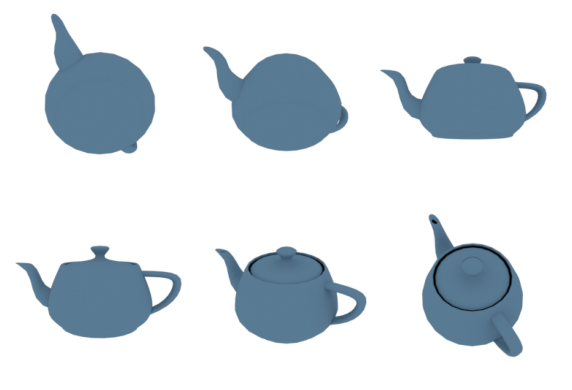

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1).imshow(images[i] ** (1.0 / 2.2))
    plt.axis("off")

## *Reference API*

- [<code>mitsuba.set_variant</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.set_variant)
- [<code>mitsuba.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.load_file)
- [<code>mitsuba.render</code>](https://mitsuba2.readthedocs.io/en/latest/generated/python_api.html#mitsuba.python.util.render)
- [<code>mitsuba.Bitmap.write</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.Bitmap.write)